# **Flux.1 Kontext Dev for Editing Images with Prompts**
- The T4 takes approximately 6 minutes to edit a 1392×752 image, while the L4 completes the same task in just around 2 minutes.
- The resolution of your image might change if it is different from the following resolutions ((672, 1568),(688, 1504),(720, 1456),(752, 1392),(800, 1328),(832, 1248),(880, 1184),(944, 1104),(1024, 1024),(1104, 944),(1184, 880)(1248, 832),(1328, 800),(1392, 752),(1456, 720),(1504, 688),(1568, 672))
- A prompting guide for flux kontext: https://docs.bfl.ai/guides/prompting_guide_kontext_i2i

In [ ]:
# @title Setup Environment
# !pip install --quiet torch torchvision --index-url https://download.pytorch.org/whl/cu124
# !pip install --upgrade --quiet torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install torch==2.6.0 torchvision==0.21.0
%cd /content

from IPython.display import clear_output
!git clone --branch ComfyUI_v0.3.43 https://github.com/Isi-dev/ComfyUI
clear_output()
%cd /content/ComfyUI/custom_nodes
!git clone https://github.com/Isi-dev/ComfyUI_Img2PaintingAssistant
!git clone https://github.com/Isi-dev/ComfyUI_GGUF.git
clear_output()
# !git clone https://github.com/Isi-dev/ComfyUI_KJNodes.git
# clear_output()
%cd /content/ComfyUI/custom_nodes/ComfyUI_GGUF
!pip install -r requirements.txt
clear_output()
# %cd /content/ComfyUI/custom_nodes/ComfyUI_KJNodes
# !pip install -r requirements.txt
# clear_output()
%cd /content/ComfyUI

import subprocess
import sys

def install_pip_packages():
    packages = [
        'torchsde',
        'av',
        'diffusers',
        # 'transformers',
        'xformers==0.0.29.post2',
        'accelerate',
        # 'omegaconf',
        # 'tqdm',
        # 'librosa',
        'einops',
        'spandrel'
    ]

    for package in packages:
        try:
            # Run pip install silently (using -q)
            subprocess.run(
                [sys.executable, '-m', 'pip', 'install', '-q', package],
                check=True,
                capture_output=True
            )
            print(f"✓ {package} installed")
        except subprocess.CalledProcessError as e:
            print(f"✗ Error installing {package}: {e.stderr.decode().strip() or 'Unknown error'}")

def install_apt_packages():
    packages = ['aria2']

    try:
        # Run apt install silently (using -qq)
        subprocess.run(
            ['apt-get', '-y', 'install', '-qq'] + packages,
            check=True,
            capture_output=True
        )
        print("✓ apt packages installed")
    except subprocess.CalledProcessError as e:
        print(f"✗ Error installing apt packages: {e.stderr.decode().strip() or 'Unknown error'}")


print("Installing pip packages...")
install_pip_packages()
clear_output()  # Clear the pip installation output

print("Installing apt packages...")
install_apt_packages()
clear_output()  # Clear the apt installation output

print("Installation completed with status:")
print("- All pip packages installed successfully" if '✗' not in install_pip_packages.__code__.co_consts else "- Some pip packages had issues")
print("- apt packages installed successfully" if '✗' not in install_apt_packages.__code__.co_consts else "- apt packages had issues")

import torch
import numpy as np
from PIL import Image
import gc
import os
import torch
from PIL import Image
import random
import imageio
from google.colab import files
from IPython.display import display, HTML, Image as IPImage
sys.path.insert(0, '/content/ComfyUI')

from nodes import (
    DualCLIPLoader,
    CLIPLoader,
    CLIPTextEncode,
    VAEEncode,
    VAEDecode,
    VAELoader,
    KSamplerAdvanced,
    ConditioningZeroOut,
    InpaintModelConditioning,
    ImageScaleBy,
    ImageScale,
    LoraLoaderModelOnly,
    LoadImage,
    SaveImage
)

from custom_nodes.ComfyUI_GGUF.nodes import UnetLoaderGGUF

from comfy_extras.nodes_edit_model import ReferenceLatent

from comfy_extras.nodes_flux import (
    FluxGuidance,
    FluxKontextImageScale
)

from comfy_extras.nodes_images import (
    ImageCrop,
    ImageStitch

)

from custom_nodes.ComfyUI_Img2PaintingAssistant.image_to_painting_node import Painting

from comfy_extras.nodes_sd3 import EmptySD3LatentImage

from comfy_extras.nodes_post_processing import ImageScaleToTotalPixels

from comfy_extras.nodes_mask import SolidMask

def image_width_height(image):
    if image.ndim == 4:
        _, height, width, _ = image.shape
    elif image.ndim == 3:
        height, width, _ = image.shape
    else:
        raise ValueError(f"Unsupported image shape: {image.shape}")
    return width, height

def compute_value_from_size(width: int, height: int) -> float:
    return float(width * height / 4)

def fillMask(width, height, mask, box=(0, 0), color=0):
    bg = Image.new("L", (width, height), color)
    bg.paste(mask, box, mask)
    return bg

def emptyImage(width, height, batch_size=1, color=0):
    r = torch.full([batch_size, height, width, 1], ((color >> 16) & 0xFF) / 0xFF)
    g = torch.full([batch_size, height, width, 1], ((color >> 8) & 0xFF) / 0xFF)
    b = torch.full([batch_size, height, width, 1], ((color) & 0xFF) / 0xFF)
    return torch.cat((r, g, b), dim=-1)

def pil2tensor(image):
  return torch.from_numpy(np.array(image).astype(np.float32) / 255.0).unsqueeze(0)

def tensor2pil(image):
    return Image.fromarray(np.clip(255. * image.cpu().numpy().squeeze(), 0, 255).astype(np.uint8))

def lanczos(samples, width, height):
    images = [Image.fromarray(np.clip(255. * image.movedim(0, -1).cpu().numpy(), 0, 255).astype(np.uint8)) for image in samples]
    images = [image.resize((width, height), resample=Image.Resampling.LANCZOS) for image in images]
    images = [torch.from_numpy(np.array(image).astype(np.float32) / 255.0).movedim(-1, 0) for image in images]
    result = torch.stack(images)
    return result.to(samples.device, samples.dtype)

def bislerp(samples, width, height):
    def slerp(b1, b2, r):
        '''slerps batches b1, b2 according to ratio r, batches should be flat e.g. NxC'''

        c = b1.shape[-1]

        #norms
        b1_norms = torch.norm(b1, dim=-1, keepdim=True)
        b2_norms = torch.norm(b2, dim=-1, keepdim=True)

        #normalize
        b1_normalized = b1 / b1_norms
        b2_normalized = b2 / b2_norms

        #zero when norms are zero
        b1_normalized[b1_norms.expand(-1,c) == 0.0] = 0.0
        b2_normalized[b2_norms.expand(-1,c) == 0.0] = 0.0

        #slerp
        dot = (b1_normalized*b2_normalized).sum(1)
        omega = torch.acos(dot)
        so = torch.sin(omega)

        #technically not mathematically correct, but more pleasing?
        res = (torch.sin((1.0-r.squeeze(1))*omega)/so).unsqueeze(1)*b1_normalized + (torch.sin(r.squeeze(1)*omega)/so).unsqueeze(1) * b2_normalized
        res *= (b1_norms * (1.0-r) + b2_norms * r).expand(-1,c)

        #edge cases for same or polar opposites
        res[dot > 1 - 1e-5] = b1[dot > 1 - 1e-5]
        res[dot < 1e-5 - 1] = (b1 * (1.0-r) + b2 * r)[dot < 1e-5 - 1]
        return res

def common_upscale(samples, width, height, upscale_method, crop):
        orig_shape = tuple(samples.shape)
        if len(orig_shape) > 4:
            samples = samples.reshape(samples.shape[0], samples.shape[1], -1, samples.shape[-2], samples.shape[-1])
            samples = samples.movedim(2, 1)
            samples = samples.reshape(-1, orig_shape[1], orig_shape[-2], orig_shape[-1])
        if crop == "center":
            old_width = samples.shape[-1]
            old_height = samples.shape[-2]
            old_aspect = old_width / old_height
            new_aspect = width / height
            x = 0
            y = 0
            if old_aspect > new_aspect:
                x = round((old_width - old_width * (new_aspect / old_aspect)) / 2)
            elif old_aspect < new_aspect:
                y = round((old_height - old_height * (old_aspect / new_aspect)) / 2)
            s = samples.narrow(-2, y, old_height - y * 2).narrow(-1, x, old_width - x * 2)
        else:
            s = samples

        if upscale_method == "bislerp":
            out = bislerp(s, width, height)
        elif upscale_method == "lanczos":
            out = lanczos(s, width, height)
        else:
            out = torch.nn.functional.interpolate(s, size=(height, width), mode=upscale_method)

        if len(orig_shape) == 4:
            return out

        out = out.reshape((orig_shape[0], -1, orig_shape[1]) + (height, width))
        return out.movedim(2, 1).reshape(orig_shape[:-2] + (height, width))

def make(image_1, direction="left-right", pixels=0, image_2=None, mask_1=None, mask_2=None):
    if image_2 is None:
      image_2 = emptyImage(image_1.shape[2], image_1.shape[1])
      mask_2 = torch.full((1, image_1.shape[1], image_1.shape[2]), 1, dtype=torch.float32, device="cpu")

    elif image_2 is not None and mask_2 is None:
      raise ValueError("mask_2 is required when image_2 is provided")
    if pixels > 0:
      _, img2_h, img2_w, _ = image_2.shape
      h = pixels if direction == 'left-right' else int(img2_h * (pixels / img2_w))
      w = pixels if direction == 'top-bottom' else int(img2_w * (pixels / img2_h))

      image_2 = image_2.movedim(-1, 1)
      image_2 = common_upscale(image_2, w, h, 'bicubic', 'disabled')
      image_2 = image_2.movedim(1, -1)

      orig_image_2 = tensor2pil(image_2)
      orig_mask_2 = tensor2pil(mask_2).convert('L')
      orig_mask_2 = orig_mask_2.resize(orig_image_2.size)
      mask_2 = pil2tensor(orig_mask_2)

    _, img1_h, img1_w, _ = image_1.shape
    _, img2_h, img2_w, _ = image_2.shape

    image, mask, context_mask = None, None, None

    # resize
    if img1_h != img2_h and img1_w != img2_w:
      width, height = img2_w, img2_h
      if direction == 'left-right' and img1_h != img2_h:
        scale_factor = img2_h / img1_h
        width = round(img1_w * scale_factor)
      elif direction == 'top-bottom' and img1_w != img2_w:
        scale_factor = img2_w / img1_w
        height = round(img1_h * scale_factor)

      image_1 = image_1.movedim(-1, 1)
      image_1 = common_upscale(image_1, width, height, 'bicubic', 'disabled')
      image_1 = image_1.movedim(1, -1)

    if mask_1 is None:
      mask_1 = torch.full((1, image_1.shape[1], image_1.shape[2]), 0, dtype=torch.float32, device="cpu")

    orig_image_1 = tensor2pil(image_1)
    orig_mask_1 = tensor2pil(mask_1).convert('L')

    if orig_mask_1.size != orig_image_1.size:
      orig_mask_1 = orig_mask_1.resize(orig_image_1.size)

    img1_w, img1_h = orig_image_1.size
    image_1 = pil2tensor(orig_image_1)
    image = torch.cat((image_1, image_2), dim=2) if direction == 'left-right' else torch.cat((image_1, image_2),
                                                                                             dim=1)

    context_mask = fillMask(image.shape[2], image.shape[1], orig_mask_1)
    context_mask = pil2tensor(context_mask)

    orig_mask_2 = tensor2pil(mask_2).convert('L')
    x = img1_w if direction == 'left-right' else 0
    y = img1_h if direction == 'top-bottom' else 0
    mask = fillMask(image.shape[2], image.shape[1], orig_mask_2, (x, y))
    mask = pil2tensor(mask)

    return (image, mask, context_mask, img2_w, img2_h, x, y)




from pathlib import Path


# download_loRA = False # @param {type:"boolean"}

lora = None

def download_with_aria2c(link, folder="/content/ComfyUI/models/loras"):
    import os

    filename = link.split("/")[-1]
    command = f"aria2c --console-log-level=error -c -x 16 -s 16 -k 1M {link} -d {folder} -o {filename}"

    print("Executing download command:")
    print(command)

    os.makedirs(folder, exist_ok=True)
    get_ipython().system(command)

    return filename



def download_civitai_model(civitai_link, civitai_token, folder="/content/ComfyUI/models/loras"):
    import os
    import time

    os.makedirs(folder, exist_ok=True)

    try:
        model_id = civitai_link.split("/models/")[1].split("?")[0]
    except IndexError:
        raise ValueError("Invalid Civitai URL format. Please use a link like: https://civitai.com/api/download/models/1523247?...")

    civitai_url = f"https://civitai.com/api/download/models/{model_id}?type=Model&format=SafeTensor"
    if civitai_token:
        civitai_url += f"&token={civitai_token}"

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    filename = f"model_{timestamp}.safetensors"

    full_path = os.path.join(folder, filename)

    download_command = f"wget --max-redirect=10 --show-progress \"{civitai_url}\" -O \"{full_path}\""
    print("Downloading from Civitai...")

    os.system(download_command)

    local_path = os.path.join(folder, filename)
    if os.path.exists(local_path) and os.path.getsize(local_path) > 0:
        print(f"LoRA downloaded successfully: {local_path}")
    else:
        print(f"❌ LoRA download failed or file is empty: {local_path}")

    return filename


def download_lora(link, folder="/content/ComfyUI/models/loras", civitai_token=None):
    """
    Download a model file, automatically detecting if it's a Civitai link or huggingface download.

    Args:
        link: The download URL (either huggingface or Civitai)
        folder: Destination folder for the download
        civitai_token: Optional token for Civitai downloads (required if link is from Civitai)

    Returns:
        The filename of the downloaded model
    """
    if "civitai.com" in link.lower():
        if not civitai_token:
            raise ValueError("Civitai token is required for Civitai downloads")
        return download_civitai_model(link, civitai_token, folder)
    else:
        return download_with_aria2c(link, folder)

# flux_lora_download_url = "https://huggingface.co/RiverZ/normal-lora/resolve/main/pytorch_lora_weights.safetensors"# @param {"type":"string"}
# token_if_civitai_url = "Put your civitai token here"# @param {"type":"string"}

# lora = download_lora(flux_lora_download_url, civitai_token=token_if_civitai_url)
# # Validate loRA file extension
# valid_extensions = {'.safetensors', '.ckpt', '.pt', '.pth', '.sft'}
# if lora:
#     if not any(lora.lower().endswith(ext) for ext in valid_extensions):
#         print(f"❌ Invalid LoRA format: {lora}")
#         lora = None
#     else:
#         clear_output()
#         print("loRA downloaded succesfully!")

def model_download(url: str, dest_dir: str, filename: str = None, silent: bool = True) -> bool:
    """
    Colab-optimized download with aria2c

    Args:
        url: Download URL
        dest_dir: Target directory (will be created if needed)
        filename: Optional output filename (defaults to URL filename)
        silent: If True, suppresses all output (except errors)

    Returns:
        bool: True if successful, False if failed
    """
    try:
        # Create destination directory
        Path(dest_dir).mkdir(parents=True, exist_ok=True)

        # Set filename if not specified
        if filename is None:
            filename = url.split('/')[-1].split('?')[0]  # Remove URL parameters

        # Build command
        cmd = [
            'aria2c',
            '--console-log-level=error',
            '-c', '-x', '16', '-s', '16', '-k', '1M',
            '-d', dest_dir,
            '-o', filename,
            url
        ]

        # Add silent flags if requested
        if silent:
            cmd.extend(['--summary-interval=0', '--quiet'])
            print(f"Downloading {filename}...", end=' ', flush=True)

        # Run download
        result = subprocess.run(cmd, check=True, capture_output=True, text=True)

        if silent:
            print("Done!")
        else:
            print(f"Downloaded {filename} to {dest_dir}")
        return filename

    except subprocess.CalledProcessError as e:
        error = e.stderr.strip() or "Unknown error"
        print(f"\nError downloading {filename}: {error}")
        return False
    except Exception as e:
        print(f"\nError: {str(e)}")
        return False


flux_model = model_download("https://huggingface.co/Isi99999/Upscalers/resolve/main/Flux/flux1-kontext-dev-Q6_K.gguf", "/content/ComfyUI/models/unet")
# flux_model = model_download("https://huggingface.co/Isi99999/Upscalers/resolve/main/Flux/flux1-dev-fp8.safetensors", "/content/ComfyUI/models/unet")
flux_vae = model_download("https://huggingface.co/Isi99999/Upscalers/resolve/main/Flux/ae.sft", "/content/ComfyUI/models/vae")
flux_clip_l = model_download("https://huggingface.co/Isi99999/Upscalers/resolve/main/Flux/clip_l.safetensors", "/content/ComfyUI/models/clip")
flux_t5xxl = model_download("https://huggingface.co/Isi99999/Upscalers/resolve/main/Flux/t5xxl_fp8_e4m3fn.safetensors", "/content/ComfyUI/models/clip")

clip_loader = DualCLIPLoader()
unet_loader =  UnetLoaderGGUF()
# unet_loader =  UNETLoader()
vae_loader =   VAELoader()
vae_encode = VAEEncode()
vae_decode = VAEDecode()
ksampler = KSamplerAdvanced()
load_lora = LoraLoaderModelOnly()
load_image = LoadImage()
load_image2 = LoadImage()
save_image = SaveImage()
positive_prompt_encode = CLIPTextEncode()
negative_prompt_encode = ConditioningZeroOut()
inpaint_model_conditioning = InpaintModelConditioning()
empty_latent_image = EmptySD3LatentImage()
flux_guidance = FluxGuidance()
flux_kontext_scale = FluxKontextImageScale()
image_stitch = ImageStitch()
reference_latent = ReferenceLatent()
imageScaleToTotalPixels = ImageScaleToTotalPixels()
# umage_resize = ImageResizeKJ()
solid_mask = SolidMask()
image_scaler1 = ImageScale()
image_scaler = ImageScale()
image_scale_by = ImageScaleBy()
image_crop = ImageCrop()
paint = Painting()

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    for obj in list(globals().values()):
        if torch.is_tensor(obj) or (hasattr(obj, "data") and torch.is_tensor(obj.data)):
            del obj
    gc.collect()


def save_as_image(image, filename_prefix, output_dir="/content/ComfyUI/output"):
    """Save single frame as PNG image."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.png"

    frame = (image.cpu().numpy() * 255).astype(np.uint8)

    Image.fromarray(frame).save(output_path)

    return output_path


def save_as_mp4(images, filename_prefix, fps, output_dir="/content/ComfyUI/output"):
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/{filename_prefix}.mp4"

    frames = []
    for i, img in enumerate(images):
        try:

            if isinstance(img, torch.Tensor):
                img = img.cpu().numpy()

            # print(f"Frame {i} initial shape: {img.shape}, dtype: {img.dtype}, max: {img.max()}")  # Debug


            if img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)


            if len(img.shape) == 4:  # Batch dimension? (N, C, H, W)
                img = img[0]  # Take first image in batch

            if len(img.shape) == 3:
                if img.shape[0] in (1, 3, 4):  # CHW format
                    img = np.transpose(img, (1, 2, 0))
                elif img.shape[2] > 4:  # Too many channels
                    img = img[:, :, :3]
            elif len(img.shape) == 2:
                img = np.expand_dims(img, axis=-1)

            # print(f"Frame {i} processed shape: {img.shape}")  # Debug

            # Final validation
            if len(img.shape) != 3 or img.shape[2] not in (1, 3, 4):
                raise ValueError(f"Invalid frame shape after processing: {img.shape}")

            frames.append(img)
        except Exception as e:
            print(f"Error processing frame {i}: {str(e)}")
            raise

    try:
        with imageio.get_writer(output_path, fps=fps) as writer:
            for i, frame in enumerate(frames):
                # print(f"Writing frame {i} with shape: {frame.shape}")  # Debug
                writer.append_data(frame)
    except Exception as e:
        print(f"Error writing video: {str(e)}")
        raise

    return output_path

import cv2
import shutil
from IPython.display import Video
import datetime


def upload_file():
    """Handle file upload (image or video) and return paths."""
    os.makedirs('/content/ComfyUI/input', exist_ok=True)
    uploaded = files.upload()

    paths = []
    for filename in uploaded.keys():
        src_path = f'/content/ComfyUI/{filename}'
        dest_path = f'/content/ComfyUI/input/{filename}'
        shutil.move(src_path, dest_path)
        paths.append(dest_path)
        print(f"File saved to: {dest_path}")

    return paths[0] if paths else None

def display_video(video_path):
    from IPython.display import HTML
    from base64 import b64encode

    video_data = open(video_path,'rb').read()

    # Determine MIME type based on file extension
    if video_path.lower().endswith('.mp4'):
        mime_type = "video/mp4"
    elif video_path.lower().endswith('.webm'):
        mime_type = "video/webm"
    elif video_path.lower().endswith('.webp'):
        mime_type = "image/webp"
    else:
        mime_type = "video/mp4"  # default

    data_url = f"data:{mime_type};base64," + b64encode(video_data).decode()

    display(HTML(f"""
    <video width=512 controls autoplay loop>
        <source src="{data_url}" type="{mime_type}">
    </video>
    """))

outputImagePath = None

def edit_input(
    image_path: str = None,
    image_path2: str = None,
    positive_prompt: str = "",
    guidance: float = 2.5,
    change_resolution: bool = False,
    width: int = 832,
    height: int = 480,
    change_output_resolution: bool = False,
    width_out: int = 1024,
    height_out: int = 1024,
    seed: int = 0,
    steps: int = 20,
    cfg: float = 1.0,
    sampler_name: str = "euler",
    scheduler: str = "simple",
    denoise: float = 1.0,
    overwrite: bool = False

):

    with torch.inference_mode():

        print("Loading Text_Encoder...")
        clip = clip_loader.load_clip(flux_t5xxl, flux_clip_l, "flux")[0]

        # positive_prompt = f'A diptych with two side-by-side images of the same scene. On the right, the scene is exactly the same as on the left but {positive_prompt}'

        prompt_encode = positive_prompt_encode.encode(clip, positive_prompt)[0]

        negative = negative_prompt_encode.zero_out(prompt_encode)[0]


        del clip
        torch.cuda.empty_cache()
        gc.collect()



        if image_path is None:
            print("Please upload an image")
            image_path = upload_file()
        if image_path is None:
            print("No image uploaded!")
        # loaded_image = load_image.load_image(image_path)[0]

        output_path = ""
        base_name = "edited_Image"
        if not overwrite:
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            base_name += f"_{timestamp}"

        try:
            if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Single image processing
                image = load_image.load_image(image_path)[0]
                if change_resolution:
                        image = image_scaler1.upscale(
                            image,
                            "lanczos",
                            width,
                            height,
                            "disabled"
                        )[0]


                if image_path2 is not None:
                    image2 = load_image2.load_image(image_path2)[0]
                    width_int, height_int = image_width_height(image)
                    width_int2, height_int2 = image_width_height(image2)
                    if width_int != width_int2 or height_int != height_int2:
                        image2 = image_scaler.upscale(
                            image2,
                            "lanczos",
                            width_int,
                            height_int,
                            "disabled"
                        )[0]
                else:
                    image2 = None
                print("Processing Image...")
                # width_int, height_int = image_width_height(loaded_image)
                # megapixels = compute_value_from_size(width_int, height_int)

                # image_pixels = imageScaleToTotalPixels.upscale(loaded_image, "nearest-exact", megapixels)[0]

                # width_int, height_int = image_width_height(image_pixels)

                # image, image_width, image_height = image_resize.resize(loaded_image, width_int, height_int, False, "nearest-exact", 2)


                # image = image_scale_by.upscale(loaded_image, "lanczos",0.5)[0]

                # width_int, height_int = image_width_height(image)


                # print("Applying solid mask...")
                # mask = solid_mask.solid(1.00, width_int, height_int)[0]

                # # print("Making image for ICLora")
                # image, mask, *_ = make(image, direction="left-right", pixels=0, image_2=image, mask_1=None, mask_2=mask)

                stitched_image = image_stitch.stitch(
                    image,
                    "right",
                    True,
                    0,
                    "white",
                    image2,
                )[0]


                scaled_image = flux_kontext_scale.scale(stitched_image)[0]

                print("Loading VAE...")
                vae = vae_loader.load_vae(flux_vae)[0]

                latent = vae_encode.encode(vae, scaled_image)[0]

                conditioning = reference_latent.append(prompt_encode, latent)[0]

                positive = flux_guidance.append(conditioning, guidance)[0]

                # positive, negative, latent = inpaint_model_conditioning.encode(positive, negative, image, vae, mask)

                print("Loading Unet Model...")
                model = unet_loader.load_unet(flux_model)[0]
                # model = unet_loader.load_unet(flux_model, "default")[0]



                # if lora is not None:
                #     print("Loading Lora...")
                #     model = load_lora.load_lora_model_only(model, lora, LoRA_Strength)[0]

                if change_output_resolution:
                    latent = empty_latent_image.generate(width_out, height_out, 1)[0]

                clear_output()

                print("Editing image...")
                image_out_latent = ksampler.sample(
                    model=model,
                    add_noise="enable",
                    noise_seed=seed,
                    steps=steps,
                    cfg=cfg,
                    sampler_name=sampler_name,
                    scheduler=scheduler,
                    positive=positive,
                    negative=negative,
                    latent_image=latent,
                    start_at_step=0,
                    end_at_step=1000,
                    return_with_leftover_noise="disable"

                )[0]

                del model
                torch.cuda.empty_cache()
                gc.collect()

                print("Decoding latents...")
                decoded = vae_decode.decode(vae, image_out_latent)[0]

                del vae
                torch.cuda.empty_cache()
                gc.collect()

                # only_result_image = image_crop.crop(decoded,width_int, height_int,width_int,0)[0]

                global outputImagePath
                base_name = "ComfyUI"
                if not overwrite:
                    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                    base_name += f"_{timestamp}"

                outputImagePath = save_as_image(decoded[0], base_name)
                display(IPImage(filename=outputImagePath))

        except Exception as e:
            print(f"Error during Image Editing/saving: {str(e)}")
            raise
        finally:
            clear_memory()

def adjust_color_properties(
    image_path: str = None,
    brightness: float = 1,
    hue: float = 0,
    saturation: float = 1.1,
    lightness: float = 1.4,
    overwrite: bool = False
):
    image = load_image.load_image(image_path)[0]
    _ , painted = paint.process(image, 26, 1, 7, brightness, hue, saturation, lightness, 1, correct_black_Img=False)

    base_name = "ComfyUI"
    if not overwrite:
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        base_name += f"_{timestamp}"

    imageToPaint = save_as_image(painted[0], base_name)
    display(IPImage(filename=imageToPaint))


file_uploaded = None
file_uploaded2 = None


print("✅ Environment Setup Complete!")



Saving untitled.png to untitled.png
File saved to: /content/ComfyUI/input/untitled.png


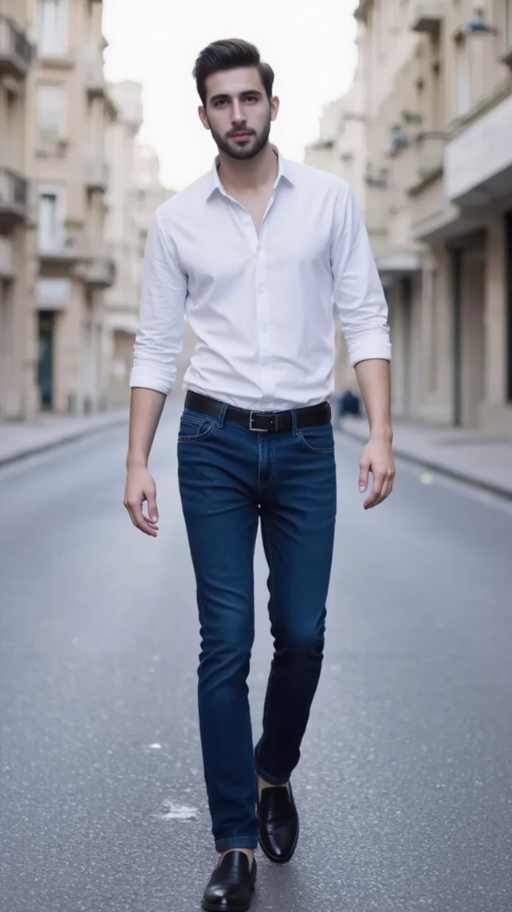

In [7]:
# @title Upload Image 1

file_uploaded = upload_file()
display_upload = True # @param {type:"boolean"}
if display_upload:
    if file_uploaded.lower().endswith(('.png', '.jpg', '.jpeg')):
        display(IPImage(filename=file_uploaded))
    else:
        print("Image format cannnot be displayed.")


In [ ]:
# @title Upload Image 2 (optional)

file_uploaded2 = upload_file()
display_upload = False # @param {type:"boolean"}
if display_upload:
    if file_uploaded2.lower().endswith(('.png', '.jpg', '.jpeg')):
        display(IPImage(filename=file_uploaded2))
    else:
        print("Image format cannnot be displayed.")


Editing image...


  0%|          | 0/20 [00:00<?, ?it/s]

Decoding latents...


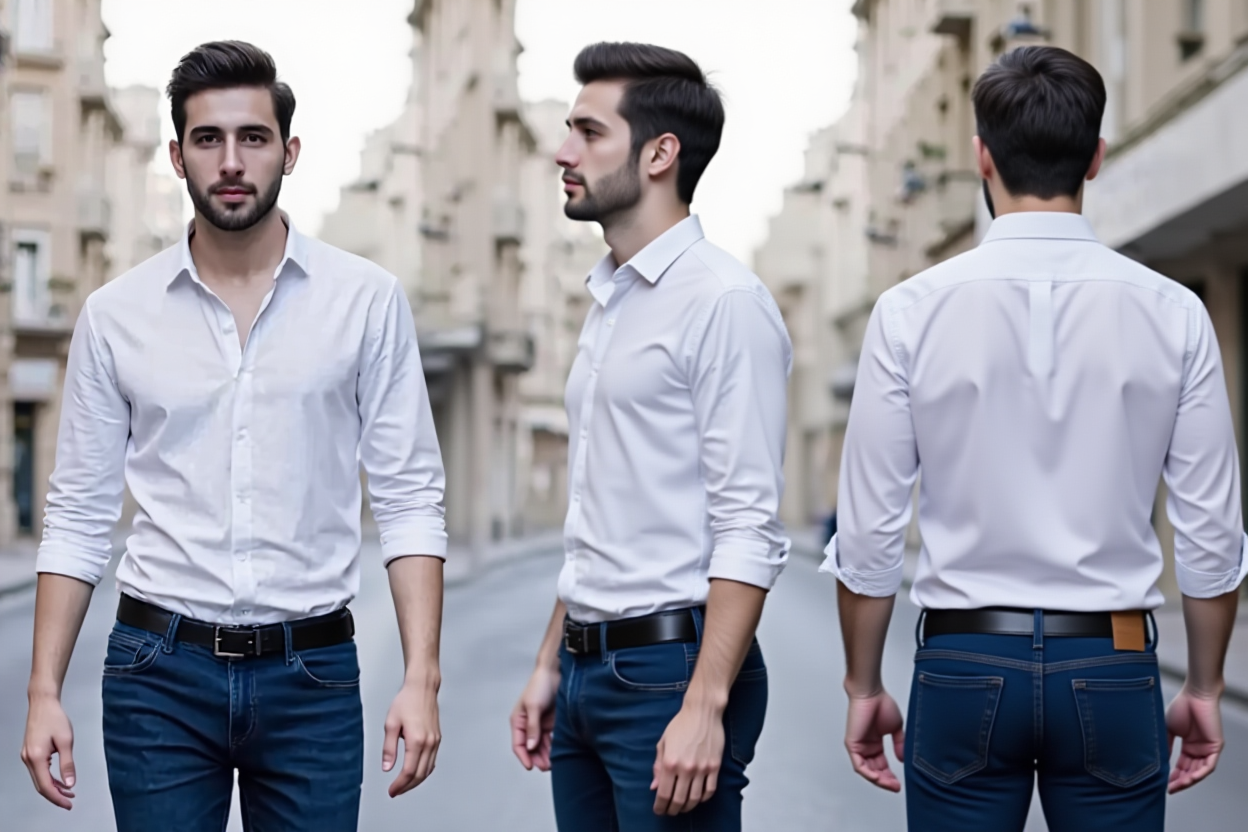

In [6]:
# @title Edit Image

positive_prompt="Change the image to show the front view, side view, and back view" # @param {"type":"string"}
guidance=2.5 # @param {"type":"slider","min":0.0,"max":100.0,"step":0.1}
# @markdown ---
# @markdown ### Image Settings
change_resolution=False # @param {type:"boolean"}
new_width = 752 # @param {"type":"number"}
new_height = 1392 # @param {"type":"number"}
change_output_resolution=True # @param {type:"boolean"}
width_out = 1248 # @param {"type":"number"}
height_out = 832 # @param {"type":"number"}
edit_output_image=False # @param {type:"boolean"}
overwrite_previous_output=False # @param {type:"boolean"}
# @markdown ---
# @markdown ### Sampler Settings
seed=1000 # @param {"type":"integer"}
steps = 20 # @param {"type":"slider","min":0,"max":100,"step":1}
cfg = 1 # @param {"type":"slider","min":0,"max":20,"step":1}
sampler_name="euler" # @param ["uni_pc", "uni_pc_bh2", "ddim","euler", "euler_cfg_pp", "euler_ancestral", "euler_ancestral_cfg_pp", "heun", "heunpp2","dpm_2", "dpm_2_ancestral","lms", "dpm_fast", "dpm_adaptive", "dpmpp_2s_ancestral", "dpmpp_2s_ancestral_cfg_pp", "dpmpp_sde", "dpmpp_sde_gpu","dpmpp_2m", "dpmpp_2m_cfg_pp", "dpmpp_2m_sde", "dpmpp_2m_sde_gpu", "dpmpp_3m_sde", "dpmpp_3m_sde_gpu", "ddpm", "lcm","ipndm", "ipndm_v", "deis", "res_multistep", "res_multistep_cfg_pp", "res_multistep_ancestral", "res_multistep_ancestral_cfg_pp","gradient_estimation", "er_sde", "seeds_2", "seeds_3"]
scheduler="simple" # @param ["simple","normal","karras","exponential","sgm_uniform","ddim_uniform","beta","linear_quadratic","kl_optimal"]
denoise=1 # @param {"type":"slider","min":0.0,"max":1.0,"step":0.01}


if edit_output_image and outputImagePath is not None:
    file_uploaded = outputImagePath
    file_uploaded2 = None

import random
seed = seed if seed != 0 else random.randint(0, 2**32 - 1)
print(f"Using seed: {seed}")

edit_input(
    image_path = file_uploaded,
    image_path2 = file_uploaded2,
    positive_prompt = positive_prompt,
    guidance = guidance,
    change_resolution=change_resolution,
    width=new_width,
    height=new_height,
    change_output_resolution=change_output_resolution,
    width_out=width_out,
    height_out=height_out,
    seed = seed,
    steps = steps,
    cfg = cfg,
    sampler_name = sampler_name,
    scheduler = scheduler,
    denoise = denoise,
    overwrite = overwrite_previous_output
)

clear_memory()

1 image received for conversion to Painting
Conversion complete!


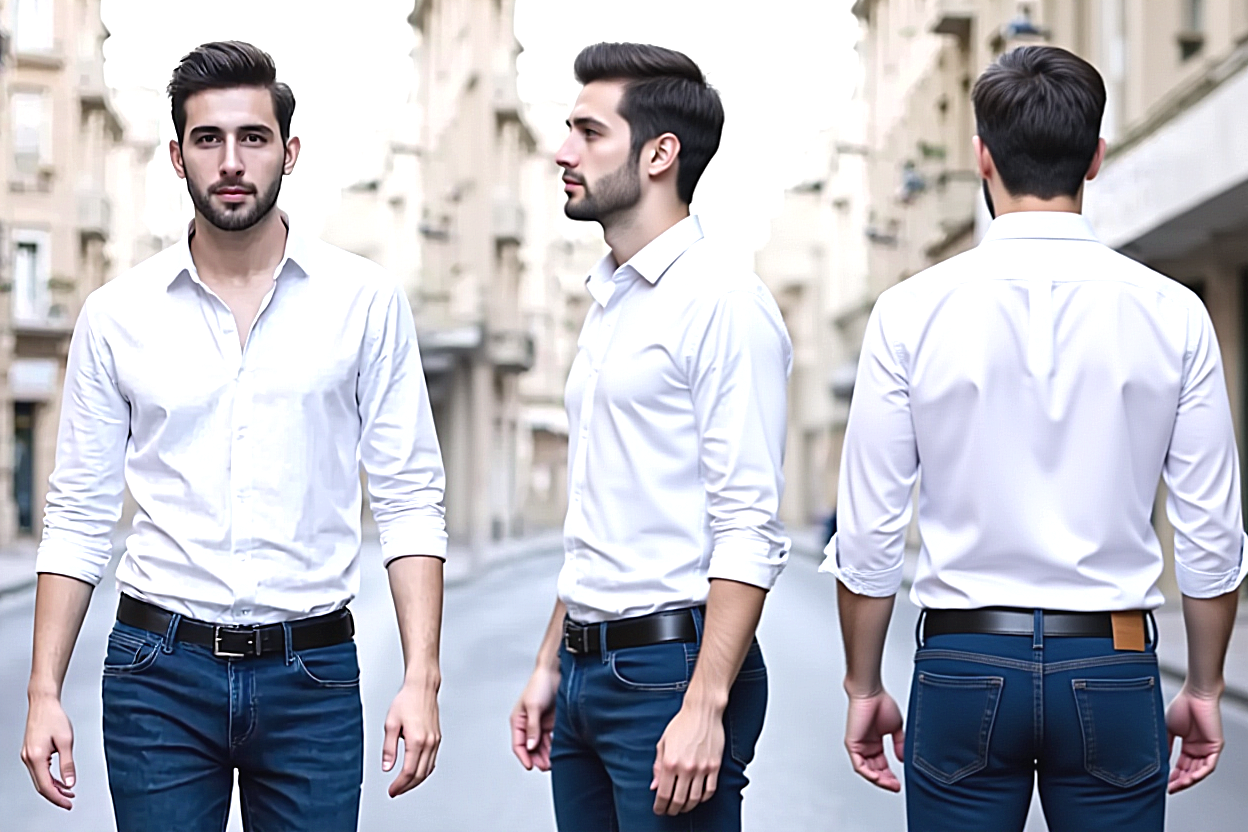

In [9]:
# @title Adjust Color Properties

brightness=1.1 # @param {"type":"slider","min":0.1,"max":10,"step":0.1}
hue=0 # @param {"type":"slider","min":0,"max":179,"step":1}
saturation=1 # @param {"type":"slider","min":0.1,"max":10,"step":0.1}
lightness=1.4 # @param {"type":"slider","min":0.1,"max":10,"step":0.1}
overwrite_previous_output=False # @param {type:"boolean"}

adjust_color_properties(
    image_path=outputImagePath,
    brightness=brightness,
    hue=hue,
    saturation=saturation,
    lightness=lightness,
    overwrite = overwrite_previous_output
)